In [1]:
import nltk
import spacy
import gensim
import numpy as np
import pandas as pd
import os
import networkx as nx

In [2]:
data_path = './new_data/'
from spacy.tokens.doc import Doc
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
stop_words = list(STOP_WORDS)
legal_stop_words = ['petitioner','petition','respondent','respondents','court','appellant','appellants','appeal']

In [3]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
def remove_stopwords(text):
    keywords = []
    doc = nlp(text)
    for token in doc:
        if(token.text not in STOP_WORDS ):
                keywords.append(token.text)
    return ' '.join(keywords)

In [5]:
def remove_punctuation(text):
    keywords = []
    doc = nlp(text)
    for token in doc:
        if(token.text not in punctuation ):
                keywords.append(token.text)
    return ' '.join(keywords)

In [6]:
def remove_legalwords(text):
    keywords = []
    doc = nlp(text)
    for token in doc:
        if(token.text not in legal_stop_words ):
                keywords.append(token.text)
    return ' '.join(keywords)

## Preprocessing

In [7]:
def preprocess(data_path):
    filename = ""
    for textfile in os.listdir(data_path):
        filename = os.path.join(data_path,textfile)
        f = open(filename,'r',encoding='iso-8859-15')
        text = f.read()
        text = text.lower()
        text = remove_stopwords(text)
       # text = remove_punctuation(text)
        text = remove_legalwords(text)
        break
    return text, filename

In [8]:
processed_data, filename = preprocess(data_path)

In [9]:
processed_list = processed_data.split()
#processed_list

In [10]:
filename

'./new_data/1962_166769.txt'

## Finding Nouns

In [11]:
doc = nlp(processed_data)
concept_words =[]
for token in doc:
    if token.pos_ == "NOUN":
       concept_words.append(token.text)

concept_words

['applications',
 'appeals',
 'section',
 'act',
 'ejectment',
 'sir',
 'bolders',
 'land',
 'occupancy',
 'tenants',
 'period',
 'years',
 'retain',
 'possession',
 'section',
 'act',
 'notice',
 'ejectment',
 'land',
 'suit',
 'air',
 'sir',
 'holders',
 'rate',
 'rupees',
 'provinces',
 'oudh',
 'acres',
 'sir',
 'land',
 'clause',
 'tenants',
 'land',
 'dispute',
 'accordance',
 'ss',
 'paper',
 'tehsilder',
 'assistant',
 'collector',
 'charge',
 'sub',
 'division',
 'accordance',
 'provisions',
 'section',
 'act',
 'applications',
 'ejectment',
 'plaints',
 'proceedings',
 'suits',
 'sub',
 'a.',
 'file',
 'extracts',
 'papers',
 'tenants',
 'air',
 'parties',
 'sub',
 'officer',
 'contention',
 'suits',
 'land',
 'suit',
 'air',
 'air',
 'holders',
 'rate',
 'rupees',
 'acres',
 'air',
 'land',
 'acres',
 'period',
 'commissioner',
 'benaras',
 'contentions',
 'trial',
 'requirements',
 'section',
 'act',
 'amendment',
 'act',
 'force',
 'appeals',
 'commissioner',
 'findings',


## Calculating Tf-IDF of all the preprocessed words

In [12]:
from gensim import corpora
from gensim import models
from collections import defaultdict

#f = open(filename,'r',encoding='iso-8859-15')
text = processed_data

# Sentence split by end_of_line(\n)
doc_set = [doc.strip() for doc in text.split('\n')]
texts = [[word for word in doc.lower().split()] for doc in doc_set]

# Create a dictionary from the sentences
dictionary = corpora.Dictionary(texts)

# Create a document-term matrix
doc_term_matrix = [dictionary.doc2bow(text) for text in texts]

# Calculate TFIDF values
tfidf = models.TfidfModel(doc_term_matrix)

# Calculate document frequency of each word
df_dict = defaultdict(int)
for doc in doc_term_matrix:
    for id, freq in doc:
        df_dict[id] += 1

# Calculate TFIDF values for each word
tfidf_dict = {}
for id, value in tfidf[dictionary.doc2bow(text.lower().split())]:
    tfidf_dict[dictionary[id]] = value * df_dict[id]

# Calculate mean TFIDF value
mean_tfidf = sum(tfidf_dict.values()) / len(tfidf_dict)

# Identify important words
important_words = [word for word in tfidf_dict if tfidf_dict[word] > mean_tfidf]



## Finding Important concept words

In [13]:
important_concepts = [word for word in important_words if word in concept_words]
print(important_concepts)

['appeals', 'section', '-', 'act', 'ejectment', 'land', 'period', 'sir', 'acres', 'agra', 'air', 'holders', 'provinces', 'rate', 'rupees', 'suit', 'accordance', 'clause', 'proceedings', 'provisions', 'sub', 'suits', 'parties', 'khudkasht', 'commissioner', 'decree', 'trial', 'amendment', 'force', 'compliance', 'law', 'board', 'revenue', 'rules', 'thereunder', 'rights', 'documents', 'evidence', 'commencement', 'holder', 'use', 'proviso', 'facts', 'date', 'particulars', 'rule', 'tenant', 'area', 'case', 'order', 'fasli']


## Finding Co-occurrence of words

In [14]:
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter

f = open(filename,'r',encoding='iso-8859-15')
text = f.read()
text = text.lower()
text = remove_stopwords(text)
# text = remove_punctuation(text)

sentences = [doc.strip() for doc in text.split('\n')]
vocab = set(word_tokenize(text,language="english"))
#print('Vocabulary:\n',vocab,'\n')
token_sent_list = [word_tokenize(sen,language="english") for sen in sentences]
#print('Each sentence in token form:\n',token_sent_list,'\n')

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
k=2

for sen in token_sent_list:
    for ii in range(len(sen)):
        if ii < k:
            c = Counter(sen[0:ii+k+1])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c
        elif ii > len(sen)-(k+1):
            c = Counter(sen[ii-k::])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c
        else:
            c = Counter(sen[ii-k:ii+k+1])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c

# Having final matrix in dict form 
co_occ = {ii:dict(co_occ[ii]) for ii in vocab}
display(co_occ)

{'appellate': {'court': 1, 'confirmed': 1},
 '907': {'applications': 1, 'act': 1, '179': 1, 'presented': 1},
 'extracts': {'papers': 1,
  'join': 1,
  'necessary': 2,
  'file': 2,
  'documents': 1,
  '.': 1},
 'ascertaining': {'prescribe': 1,
  'behalf': 1,
  'sir': 1,
  "'": 1,
  'assist': 1,
  'court': 1,
  'provisions': 1,
  'proviso': 1,
  ',': 1,
  'purpose': 1,
  'facts': 1,
  '.': 1},
 'assist': {'ascertaining': 1, 'court': 1, 'particulars': 1, "'": 1},
 '1346': {',': 1, '1347': 1, '1345': 1, 'fasli': 1},
 'declareare': {',': 1, 'hereditary': 1, 'tenant': 1, 'shall': 1},
 '919': {',': 1, 'acres': 1, '50': 1, 'excess': 1},
 'jamabandis': {'villages': 1, '1940': 1, 'khatauni': 1, 'years': 1},
 '-': {'bolders': 1,
  'sir': 23,
  'land': 1,
  'stating': 1,
  'respondents': 1,
  'non': 1,
  'occupancy': 1,
  'tenants': 1,
  'appellants': 2,
  'holders': 3,
  ',': 7,
  'charge': 1,
  'sub': 22,
  'division': 1,
  'view': 1,
  's.': 7,
  'a': 1,
  'divisional': 4,
  'officer': 4,
  'ai

## Creating Graph

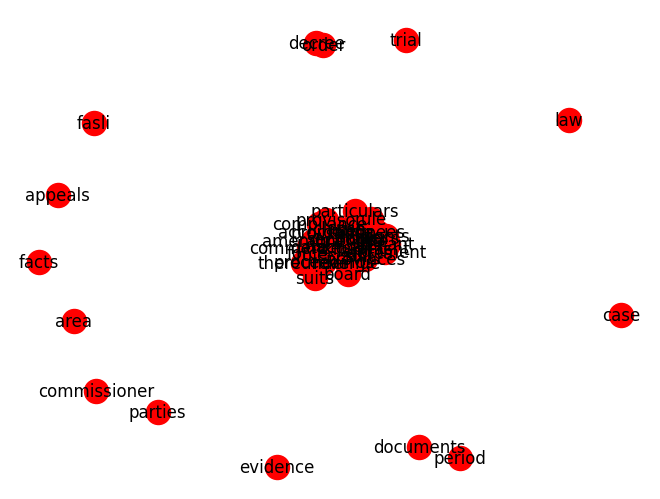

In [15]:
import networkx as nx

G = nx.Graph()

# Add nodes
G.add_nodes_from(important_concepts)

# Add edges based on co-occurrence count
for word1 in important_concepts:
    if word1 in co_occ:
        for word2, weight in co_occ[word1].items():
            if word2 in important_concepts and weight >= 3:
                G.add_edge(word1, word2, weight=weight)
nx.draw(G,with_labels=True,node_color ='r')

## Finiding Communities from the graph

In [16]:

# Find communities using Girvan-Newman algorithm
communities = nx.community.girvan_newman(G)
for c in next(communities):
    if len(c)>1:
        print(c)

{'provisions', 'proceedings', 'force', 'date', 'rules', 'use', 'amendment', 'act', 'clause', 'thereunder', 'particulars', 'proviso', 'sub', 'compliance', 'agra', 'section', 'accordance', 'suits', 'commencement'}
{'provinces', 'holder', 'rule', 'rate', 'revenue', 'board', 'ejectment', 'rupees', 'air', 'acres', 'khudkasht', '-', 'tenant', 'suit', 'holders', 'sir', 'rights', 'land'}
{'decree', 'order'}


In [17]:
# Find communities using Louvain Modularity algorithm
communities = nx.community.louvain_communities(G)
for c in communities:
    if len(c)>1:
        print(c)

{'rupees', 'rate', 'revenue', 'board', 'provinces'}
{'proviso', 'use', 'provisions', 'accordance', 'section', 'proceedings', 'suits', 'clause', 'compliance'}
{'rules', 'amendment', 'act', 'force', 'commencement', 'date', 'thereunder', 'agra'}
{'holder', 'rule', 'ejectment', 'land', 'air', 'suit', 'rights', 'acres', 'tenant', '-', 'sub', 'holders', 'sir', 'khudkasht', 'particulars'}
{'decree', 'order'}
